## Statistical Inference on a Sample Set
#### Gender Differences in Movie Screenplays
##### By I-Ching Wang, Michelle Kim, and Nikki Haas

Movies are often criticized for not giving serious roles to women, but is it really true?  Our project for this term is to explore just this question.  We have gathered lines from over 20,000 characters in scripts available from the internet move script database and hand classified genders to 1,100 randomly selected characters.  In this section of our project, we will explore the line count and frequency distribution for our characters, statistical inference and  linear regression to see what sort of insights can be gained before we build a machine learning model.

##### Part 0: Read in Data

In [180]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import confusion_matrix
import json
import re
import sys
import math
import seaborn as sns
%matplotlib inline
sys.version

'2.7.13 |Anaconda, Inc.| (default, Sep 21 2017, 17:38:20) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [18]:
df = pd.read_csv("random_sampling_genderized.csv.csv", sep = ',')
df.head()

,id,char,gender,genre,title,line_count,pkey
0,1,WILLY,M,Musical,sisteract,58,willy-sisteract
1,2,ATHOS,M,Action,manintheironmask,378,athos-manintheironmask
2,3,AUGUSTUS,M,Action,perfectcreature,222,augustus-perfectcreature
3,4,MCKEE (cont'd),NaN,Drama,adaptation,24,mckee_(cont'd)-adaptation
4,5,JIMMY,M,Romance,mulhollanddrive,43,jimmy-mulhollanddrive


In [19]:
del df['id']

In [20]:
df.shape

(2786, 6)

In [21]:
df.dropna(inplace=True)

In [33]:
df['line_count'] = df['line_count'].map(lambda x: int(x))

In [34]:
df.head()

,char,gender,genre,title,line_count,pkey
0,WILLY,M,Musical,sisteract,58,willy-sisteract
1,ATHOS,M,Action,manintheironmask,378,athos-manintheironmask
2,AUGUSTUS,M,Action,perfectcreature,222,augustus-perfectcreature
4,JIMMY,M,Romance,mulhollanddrive,43,jimmy-mulhollanddrive
5,DENNIS,M,Drama,backdraft,42,dennis-backdraft


In [35]:
df.shape

(1150, 6)

##### Part 1: Summary Statistics

In [36]:
df.gender.value_counts()

M    758
F    392
Name: gender, dtype: int64

In [81]:
s_male = df[df['gender'] == "M"]['line_count'].std()
s_female = df[df['gender'] == "F"]['line_count'].std()
a_male = df[df['gender'] == "M"]['line_count'].mean()
a_female = df[df['gender'] == "F"]['line_count'].mean()
m_male =df[df['gender'] == "M"]['line_count'].median()
m_female =df[df['gender'] == "F"]['line_count'].median()
v_male = df[df['gender'] == "M"]['line_count'].var()
v_female = df[df['gender'] == "F"]['line_count'].var()
min_female = df[df['gender'] == "F"]['line_count'].min()
max_female = df[df['gender'] == "F"]['line_count'].max()
min_male = df[df['gender'] == "M"]['line_count'].min()
max_male = df[df['gender'] == "M"]['line_count'].max()
print "Male line count average:", a_male
print "Male line count median:", m_male
print "Male line count standard deviation:", s_male
print "Male line count variance:", v_male
print 'Male line count minimum:', min_male
print 'Male line count maximum:', max_male
print "Female line count average:", a_female
print "Female line count median:", m_female
print "Female line count standard deviation:", s_female
print "Female line count variance:", v_female
print 'Female line count minimum:', min_female
print 'Female line count maximum:', max_female


Male line count average: 162.98944591
Male line count median: 70.0
Male line count standard deviation: 269.880725931
Male line count variance: 72835.6062293
Male line count minimum: 21
Male line count maximum: 2936
Female line count average: 142.086734694
Female line count median: 64.0
Female line count standard deviation: 207.077700498
Female line count variance: 42881.1740435
Female line count minimum: 21
Female line count maximum: 1610


This data was sampled randomly using `np.random` from a very large dataset, so the law of large numbers apply and this dataset is representative of the population.  Already we can see that the female characters' line data is dissimilar from the male characters'.  The frequency shows that we have nearly twice as many male characters than female characters.  The average line count for males and females are similar, but the median and standard deviations are not, indicating there is skew in our dataset.  Our next step would be to visualized our data.

##### Part 2: Data Visualization 

[]

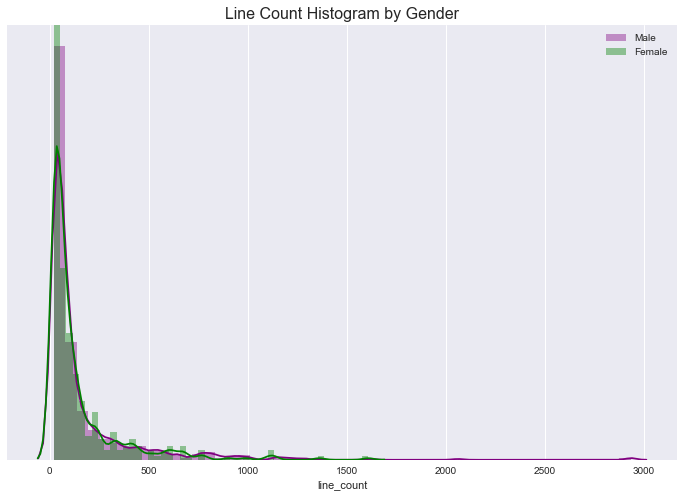

In [80]:
sns.set(style='darkgrid', palette='muted', color_codes=True)
f, axes = plt.subplots(1,1, figsize=(12,8))
plt.title("Line Count Histogram by Gender",fontsize=16)
sns.despine = True
sns.distplot(df[df['gender'] == 'M']['line_count'], color='purple', label = 'Male')
sns.distplot(df[df['gender'] == 'F']['line_count'], color='green', label = 'Female')
plt.setp(axes, yticks=[])
plt.legend()
plt.plot()

The skew on this dataset shows a lognormal or power law distribution.  To work further with this data in a linear fashion, we will have to convert it to a log-log space.

In [102]:
df['log_line_count'] = df['line_count'].map(lambda x: math.log(x))

[]

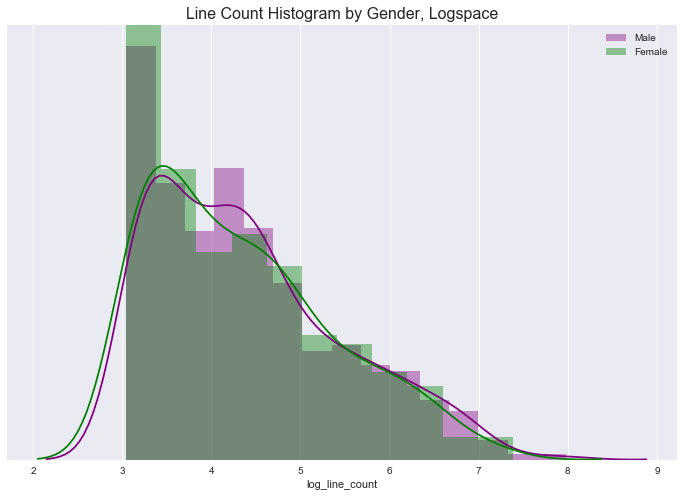

In [106]:
sns.set(style='darkgrid', palette='muted', color_codes=True)
f, axes = plt.subplots(1,1, figsize=(12,8))
plt.title("Line Count Histogram by Gender, Logspace",fontsize=16)
sns.despine = True
sns.distplot(df[df['gender'] == 'M']['log_line_count'], color='purple', hist=True, label = 'Male')
sns.distplot(df[df['gender'] == 'F']['log_line_count'], color='green', hist=True, label = 'Female')
plt.setp(axes, yticks=[])
plt.legend()
plt.plot()

Even using a logspace, we do not have a normal distribution.  It does not seem that we will be able to build a linear model for the line counts.  One thing to note is the peak for female roles is greater in count but fewer in words when compared to men.  That indicates that women are more likely to have smaller roles than men.

Next, let us look at the data by genre, to see if there is much of a difference.

In [133]:
df['genre'].value_counts()

Drama        248
Thriller     159
Comedy       156
Action       105
Crime         96
Romance       85
Adventure     56
Sci-Fi        47
Mystery       47
Fantasy       41
Horror        41
Family        18
War           15
Animation     12
Musical       11
Western        8
Music          2
Biography      2
Film-Noir      1
Name: genre, dtype: int64

[]

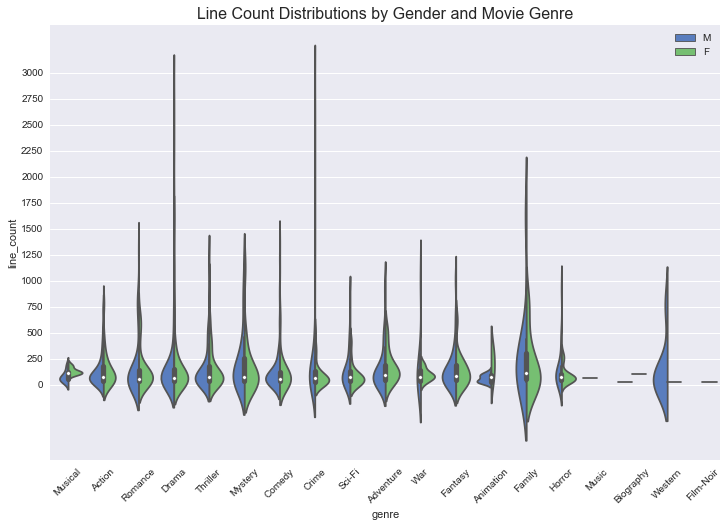

In [135]:
sns.set(style='darkgrid', palette='muted', color_codes=True)
f, axes = plt.subplots(1,1, figsize=(12,8))
plt.title("Line Count Distributions by Gender and Movie Genre",fontsize=16)
sns.despine = True
sns.violinplot(data = df, x ="genre", y="line_count", hue="gender",split=True)
plt.xticks(rotation=45)
plt.setp(axes, yticks=a)
plt.legend()
plt.plot()

While the line count distributions were not normal when looking at the sample space, the distributions for several of the genres pivoted by gender do look normal.  For instace, Mystery, Romance, Fantasy and Family all appear to have nearly-normal distributions.  We will not attempt inference by genre at this time, as the data is too sparse to make a meaningful analysis.

##### Part 3: Statistical Inference

_Un-altered data_

Our data is not normally distributed, which can hinder our analysis.  However, we have more than 30 datapoints and our data was selected in a truly random fashion.  Therefore we can run a Z-test on our data and report back the analysis.

_Hypotheses_

$H_{0} = $ The mean count of lines spoken by men and women is the same.

$H_{A} = $ There is a difference between the mean line count of men and women in movies.


_Required Calculations_

$\alpha = 0.05$

$Z = \frac{avg_{f} - avg_{m}}{stdev_{m}}$

In [144]:
alpha = 0.05

### recall the mean and std dev from section 1 are a_[gender] and s_[gender]
 
Z = ((a_female  - a_male)*1.0)/s_male

In [145]:
Z

-0.07745166367205664

In words, our Z score tells us the mean female line count is 0.077 standard deviations below the median of the male line count.  If we were to plot this on a normal distribution, we would not have met our alpha test.  Therefore, statistical inferrence tells us that we cannot determine from the line count alone that males have more serious roles than females in movies and thus we have failed to reject the null hypothesis.

_Transformed Data_

We did see a small improvement in our data's distribution when we used a log-spaced transformation.  We should run a Z test on this as well to see if there is a difference in the logspace.

_Hypotheses_

$H_{0} = $ The mean count of log of lines spoken by men and women is the same.

$H_{A} = $ There is a difference between the log of line count of men and women in movies.


_Required Calculations_

$\alpha = 0.05$

$Z = \frac{avg_{f-log} - avg_{m-log}}{stdev_{m-log}}$

In [147]:
alpha = 0.05

a_femalelog = df[df['gender'] == "F"]['log_line_count'].mean()
a_malelog = df[df['gender'] == "M"]['log_line_count'].mean()
s_malelog = df[df['gender'] == "M"]['log_line_count'].std()
 
Zlog = ((a_femalelog  - a_malelog)*1.0)/s_malelog

In [148]:
Zlog

-0.07406174860500307

It appears that our Z-score fares no better in logspace.

#####  Part 4: Limitations

Our sampling method relied on only one draw from our population due to time constraints.  We had to manually assign genders to each character, and we have over 20,000 characters in our dataset.  We attempted to find a set that included the gender for each character in the IMDB and IMSDB that we could use to enrich our script set, but to no avail.  Our statistical inference and therefore and linear model that we could build upon this set was thus limited.  Our next steps will include: classifying more data, using NLP models such as bag-of-words to analyze the complexity of the actual words used by the characters in their moves, and implementing deep learning techniques such as CNN to gain further insight.

##### Part 5: Logistic Regression Model

In [189]:
parsed_df = df[['gender', 'log_line_count']]
parsed_df['binarized_gender'] = parsed_df['gender'].map(lambda x: 0 if x=='M' else 1)
del parsed_df['gender']

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [190]:
gen_X_train = np.array(parsed_df['log_line_count'][:-575]).reshape(-1, 1)
gen_X_test = np.array(parsed_df['log_line_count'][-575:]).reshape(-1, 1)
gen_y_train = np.array(parsed_df['binarized_gender'][:-575])
gen_y_test = np.array(parsed_df['binarized_gender'][-575:])

In [191]:
regr = LR()
regr.fit(gen_X_train, gen_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [192]:
y_pred = regr.predict(gen_X_test)

In [193]:
y_pred[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [194]:
gen_y_test[:15]

array([1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1])

In [195]:
mean_squared_error(gen_y_test, y_pred)

0.32347826086956522

In [196]:
r2_score(gen_y_test, y_pred)

-0.47814910025706925

In [197]:
confusion_matrix(gen_y_test, y_pred)

array([[389,   0],
       [186,   0]])

As expected, a Logistic Regression model fared very poorly against this data.